<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/airways_predictive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 3rd May, 2024
# Click on the button 'Open in Colab' above to work in colab

## Preliminary

In [4]:
# 0.0 Reset memory when repeating experiment
%reset -f

In [5]:
# We work both in python and R

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
# 0.1 Print output from mulitple commands in a cell
# Ref: https://stackoverflow.com/a/48036735

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Call libraries
Install software and call libraries. R is used primarily for **[Data Visualization](https://github.com/harnalashok/classification/blob/main/airways_visual_analysis.ipynb)** . Nevertheless, we install and call R libraries in this notebook also.

In [7]:
%%R

# R packages install. Takes time..
# R is used mainly for Data Visualization
# NEvertheless we install and call libraries in this notebook also

install.packages("tidyverse")
install.packages("vcd")
install.packages("vcdExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/tidyverse_2.0.0.tar.gz'
Content type 'application/x-gzip' length 704618 bytes (688 KB)
downloaded 688 KB


The downloaded source packages are in
	‘/tmp/Rtmpfj6Z0U/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘zoo’, ‘colorspace’, ‘lmtest’

trying URL 'https://cran.rstudio.com/src/contrib/zoo_1.8-14.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/colorspace_2.1-1.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/lmtest_0.9-40.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/vcd_1.4-13.tar.gz'

The downloaded source packages are in
	‘/tmp/Rtmpfj6Z0U/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘qvcalc’, ‘relimp’, ‘gnm’, ‘ca’, ‘here’

trying URL 'https://cran

In [8]:
#1.1  Data preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

#1.2 Split data into X_train/X_test
from sklearn.model_selection import train_test_split

#1.3 For cross-validation and stratified k-fold partitions
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

#1.4 Encoders
#import category_encoders as ce

#1.5 For plotting/printing
import matplotlib.pyplot as plt
import seaborn as sns
# Pretty-print tabular data in Python, a
import tabulate

#1.6 Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

#1.7 Hyperparameter search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#1.8 Classification reports
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# 1.9 Misc. Used in hyperparameter search
from scipy.stats import loguniform

In [9]:
%%R

# Call R libraries
library(tidyverse)
library(vcd)
library(vcdExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: grid
Loading required package: gnm

Attaching package: ‘vcdExtra’

The following object is masked from ‘package:dplyr’:

    summarise



In [10]:
#1.8 Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
%%R

options(warn=-1)

## Read/examine data

### Read data

In [12]:
# 2.1 Read data from github repo

df=pd.read_csv('https://raw.githubusercontent.com/harnalashok/classification/refs/heads/main/data/airways_mod_ver4.csv')
df.shape   # (1000, 13)

(1000, 13)

In [13]:
%%R

# 2.1.1 Read data in R dataframe

df_r <- read.csv("https://raw.githubusercontent.com/harnalashok/classification/refs/heads/main/data/airways_mod_ver4.csv")

# Rename columns
colnames(df_r) <- c("age", "sex", "height", "subluxation_of_mandible", "head_and_neck_movement",
                  "buck_teeth", "edentulous", "bmi", "sternomental_distance",
                  "thyromental_distance", "mallampatti", "mouth_opening", "cormack_lehane")

# Display two rows
head(df_r,2)


  age    sex height subluxation_of_mandible head_and_neck_movement buck_teeth
1  22   male    172                       1                      0          1
2  55 female    143                       1                      0          1
  edentulous   bmi sternomental_distance thyromental_distance mallampatti
1          0 22.40                    17                  8.6           2
2          0 27.45                    16                  7.8           2
  mouth_opening cormack_lehane
1             0              2
2             0              1


In [14]:
# 2.1.1 Data stats

df.head()
df.describe()
df.info()

,age,sex,height,subluxation of mandible,head and neck movement,buck teeth,edentulous,bmi,sternomental distance,thyromental distance,mallampatti,mouth opening,cormack lehane
0,22,male,172,1,0,1,0.0,22.40,17.0,8.6,2,0,2
1,55,female,143,1,0,1,0.0,27.45,16.0,7.8,2,0,1
2,59,male,162,2,1,0,1.0,24.20,14.3,6.9,3,0,3
3,48,female,168,1,0,0,0.0,28.50,15.6,7.2,3,0,2
4,51,female,154,3,0,0,1.0,25.30,14.3,6.7,4,1,4


,age,height,subluxation of mandible,head and neck movement,buck teeth,edentulous,bmi,sternomental distance,thyromental distance,mallampatti,mouth opening,cormack lehane
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,998.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000
mean,43.498000,163.035000,0.206000,0.104000,0.259000,0.173347,23.895350,16.935400,8.101800,1.9100,0.010000,1.826000
std,11.742823,11.470804,0.491738,0.305413,0.440583,0.378737,3.869877,1.592276,0.919566,0.6902,0.099549,0.714307
min,20.000000,132.000000,0.000000,0.000000,0.000000,0.000000,13.800000,12.500000,5.600000,1.0000,0.000000,1.000000
25%,34.000000,155.000000,0.000000,0.000000,0.000000,0.000000,21.400000,16.000000,7.500000,1.0000,0.000000,1.000000
50%,45.000000,163.000000,0.000000,0.000000,0.000000,0.000000,24.000000,17.000000,8.000000,2.0000,0.000000,2.000000
75%,54.000000,171.000000,0.000000,0.000000,1.000000,0.000000,26.525000,18.000000,8.600000,2.0000,0.000000,2.000000
max,64.000000,195.000000,3.000000,1.000000,2.000000,1.000000,37.000000,22.000000,11.000000,4.0000,1.000000,4.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1000 non-null   int64  
 1   sex                      1000 non-null   object 
 2   height                   1000 non-null   int64  
 3   subluxation of mandible  1000 non-null   int64  
 4   head and neck movement   1000 non-null   int64  
 5   buck teeth               1000 non-null   int64  
 6   edentulous               998 non-null    float64
 7   bmi                      1000 non-null   float64
 8   sternomental distance    1000 non-null   float64
 9   thyromental distance     1000 non-null   float64
 10  mallampatti              1000 non-null   int64  
 11  mouth opening            1000 non-null   int64  
 12  cormack lehane           1000 non-null   int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 101.7+ KB


Our `age` varies from 20 to 64. `bmi` ranges from 13.8 to 37. `edentulous` has two null values.

###  Recheck column names

In [15]:
#2.2 Remove leading/trailing spaces from col names
df.columns = df.columns.str.strip()
# Within a col name keep single space
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True)  # Replaces multiple spaces with a single space
df.head()

,age,sex,height,subluxation of mandible,head and neck movement,buck teeth,edentulous,bmi,sternomental distance,thyromental distance,mallampatti,mouth opening,cormack lehane
0,22,male,172,1,0,1,0.0,22.40,17.0,8.6,2,0,2
1,55,female,143,1,0,1,0.0,27.45,16.0,7.8,2,0,1
2,59,male,162,2,1,0,1.0,24.20,14.3,6.9,3,0,3
3,48,female,168,1,0,0,0.0,28.50,15.6,7.2,3,0,2
4,51,female,154,3,0,0,1.0,25.30,14.3,6.7,4,1,4


### Drop NA rows
Only two rows get dropped. We now have 998 observations

In [16]:
# 2.3
df.isna().sum()
# We have only two rows where edentulous is null
# Drop those rows
df = df.dropna()
# Change the type of 'edentulous' from float64 to int64
df['edentulous'] = df['edentulous'].astype('int64')
df.dtypes

,0
age,0
sex,0
height,0
subluxation of mandible,0
head and neck movement,0
buck teeth,0
edentulous,2
bmi,0
sternomental distance,0
thyromental distance,0


,0
age,int64
sex,object
height,int64
subluxation of mandible,int64
head and neck movement,int64
buck teeth,int64
edentulous,int64
bmi,float64
sternomental distance,float64
thyromental distance,float64


In [17]:
%%R

# We do the same with dataframe in R
df_r = na.omit(df_r)
dim(df_r)   #  998  13

[1] 998  13


In [18]:
%%R

# R: Transform cat cols to factors:

cat_cols <- c("sex", "subluxation_of_mandible", "head_and_neck_movement",
              "buck_teeth", "edentulous", "mallampatti", "mouth_opening",
              "cormack_lehane")

df_r[cat_cols] <- lapply(df_r[cat_cols], factor)
str(df_r)

'data.frame':	998 obs. of  13 variables:
 $ age                    : int  22 55 59 48 51 56 28 36 56 51 ...
 $ sex                    : Factor w/ 2 levels "female","male": 2 1 2 1 1 2 2 2 2 2 ...
 $ height                 : int  172 143 162 168 154 182 176 168 160 166 ...
 $ subluxation_of_mandible: Factor w/ 4 levels "0","1","2","3": 2 2 3 2 4 2 2 2 3 2 ...
 $ head_and_neck_movement : Factor w/ 2 levels "0","1": 1 1 2 1 1 2 1 1 1 1 ...
 $ buck_teeth             : Factor w/ 3 levels "0","1","2": 2 2 1 1 1 2 1 1 1 2 ...
 $ edentulous             : Factor w/ 2 levels "0","1": 1 1 2 1 2 1 1 1 2 1 ...
 $ bmi                    : num  22.4 27.4 24.2 28.5 25.3 ...
 $ sternomental_distance  : num  17 16 14.3 15.6 14.3 20 16.7 17.3 17 18 ...
 $ thyromental_distance   : num  8.6 7.8 6.9 7.2 6.7 9.7 8.3 7.9 8 8.8 ...
 $ mallampatti            : Factor w/ 4 levels "1","2","3","4": 2 2 3 3 4 2 1 1 2 2 ...
 $ mouth_opening          : Factor w/ 2 levels "0","1": 1 1 1 1 2 1 1 1 1 1 ...
 $ cormack_le

In [19]:
#2.4 Map 'male' and 'female' to 1 and 0

df['sex'].value_counts()

mappings = {
            'female': 0,
            'male': 1
           }

df['sex'] = df['sex'].map(mappings)
df['sex'].value_counts()

,count
sex,
female,533
male,465


,count
sex,
0,533
1,465


In [20]:
#2.5 Our cat features and num features:
#    (Exclude cormack lahane)

cat_features = ['sex', 'buck teeth', 'edentulous', 'mallampatti', 'mouth opening', 'subluxation of mandible', 'head and neck movement']
num_features = ["age", "height", "bmi", "sternomental distance", "thyromental distance"]

#2.6 Number of unique values in our cat features:

df[cat_features].nunique()

,0
sex,2
buck teeth,3
edentulous,2
mallampatti,4
mouth opening,2
subluxation of mandible,4
head and neck movement,2


In [21]:
#2.7 Convert all cat-columns to 'int16' dtype

for col in cat_features:
    df[col] = df[col].astype('int16')

# Display the updated data types
df[cat_features].dtypes


,0
sex,int16
buck teeth,int16
edentulous,int16
mallampatti,int16
mouth opening,int16
subluxation of mandible,int16
head and neck movement,int16


## Data Visulaization

   



> For Data Visualization, please see this [link](https://github.com/harnalashok/classification/blob/main/airways_visual_analysis.ipynb) in github

## Predictive Analytics

### Split into X and y

In [23]:
#3.0 We keep a copy of our data
dfc = df.copy()

#3.1 Split dfc into target and predictors
y = dfc.pop('cormack lehane')
X = dfc

### Create dataframes to store results

In [24]:
# Our accuracy dataframe
# We will store 500 accuracy points/roc points per model
# (Repeated stratifiedKfold(cv=5), 100 times)
acc_array = pd.DataFrame(np.array(range(500)), columns = ["sno:"])
roc_array = pd.DataFrame(np.array(range(500)), columns = ["sno:"])

In [25]:
# Label encode cromack lahane

le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)
print(le.transform([1,2,3,4]))

[1 2 3 4]
[0 1 2 3]


In [26]:
# Split into train/test. We may need it at some places
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 stratify = y,
                                                 test_size = 0.20,
                                                 )

### RandomForest Repeated StratifiedKFold

In [34]:
%%time

# Ref: https://stackoverflow.com/a/66022487

clf =  RandomForestClassifier(criterion='entropy',
                              n_estimators=400)


# Store (cormack lehane) classwise classification-report
# over all 100 repeated 5-fold n_splits:
total_class0 = []  # [class0] * 100
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *100]
total_class2 = []  # [class2] * 100
total_class3 = []  # [class3] * 100
# To store, class-wise roc-data, for 100 attempts
all_roc_auc = []
# To store accuracy data for 100 attempts
total_acc_list = []
count = 1

print("==******************************************" )
print("Total number of folds would be: 100 X 5 = 500" )
print("==******************************************\n\n" )

# We take 5-random folds 100 times
for i in range(100):
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)

  # Iterate 5-times ie once per split
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # Get accuracy in this particular split (averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # Get class-wise AUC scores:
      auc = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr',
                          average = None)
      print("Class-wise AUC for this fold/split:", auc)
      list_roc_auc.append(auc) # One-vs-rest auc
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")

==******************************************
Total number of folds would be: 100 X 5 = 500
==******************************************


fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.875
Class-wise AUC for this fold/split: [0.97367521 0.96174919 0.98046875 0.99444856]
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.86
Class-wise AUC for this fold/split: [0.96794577 0.92989042 0.85760206 1.        ]
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.895
Class-wise AUC for this fold/split: [0.97982906 0.95834599 0.96094503 0.99777942]
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy for this f

In [35]:
# Just check shapes of our data collectors
# n_splits: 5
# Repeated n_splits:100
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (100, 5, 4)
# AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (100, 5, 4)
# Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (100,5)

(5, 4)

(100, 5, 4)

(5, 4)

(100, 5, 4)

(5,)

(100, 5)

#### AUC scores (randomforest modeling)

In [36]:
# AUC data compilation (randomforest)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("RandomForest--Class-wise mean of AUCs:    " ,all_roc_auc_array.reshape(500,4).mean(axis=0))
# Class-wise std dev of AUCs
print("RandomForest--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(500,4).std(axis=0))

(100, 5, 4)

RandomForest--Class-wise mean of AUCs:     [0.96120872 0.95200428 0.96470122 0.98169899]
RandomForest--Class-wise std devs of AUCs: [0.01614228 0.01574501 0.03764511 0.04644967]


#### AUC distribution plot (randomforest)

In [37]:
# Classwise AUCs in 500 iterations (extratrees)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['randomforest'] = res
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['randomforest'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
print("              Class-wise AUCs")
classwise_roc.head()

              Class-wise AUCs


,class1,class2,class3,class4
0,0.973675,0.961749,0.980469,0.994449
1,0.967946,0.929890,0.857602,1.000000
2,0.979829,0.958346,0.960945,0.997779
3,0.977899,0.964937,0.998384,0.804836
4,0.954765,0.943591,0.843407,0.982729


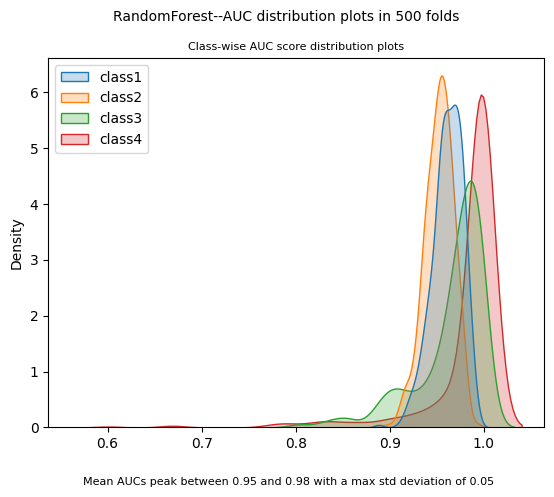

In [38]:
# AUC distribution plots--500 folds (randomforest)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("RandomForest--AUC distribution plots in 500 folds ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
min = np.round(np.min(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
max = np.round(np.max(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
maxsd = np.round(np.max(all_roc_auc_array.reshape(500,4).std(axis=0)),2)
_=plt.figtext(0.5, -0.01, f"Mean AUCs peak between {min} and {max} with a max std deviation of {maxsd}",
              ha="center",
              fontsize=8)
_=plt.show()

#### Accuracy distribution (randomforest modeling)

In [39]:
print("===randomforest=====")
acc_array['randomforest'] = np.array(total_acc_list).flatten()
print("Overall Accuracy               :", np.mean(acc_array['randomforest']))
print("Median Accuracy                :", np.median(acc_array['randomforest']))
print("Std deviation of accuracy      :", np.std(acc_array['randomforest']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(500,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(500,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

===randomforest=====
Overall Accuracy               : 0.8822910050251256
Median Accuracy                : 0.8844221105527639
Std deviation of accuracy      : 0.02404969793061389
Class-wise avg AUC score       : [0.96120872 0.95200428 0.96470122 0.98169899]
Class-wise avg std dev of AUCs : [0.01614228 0.01574501 0.03764511 0.04644967]
(for classes 1,2,3,4 respectively)


#### Distribution plot for accuracy (randomforest)

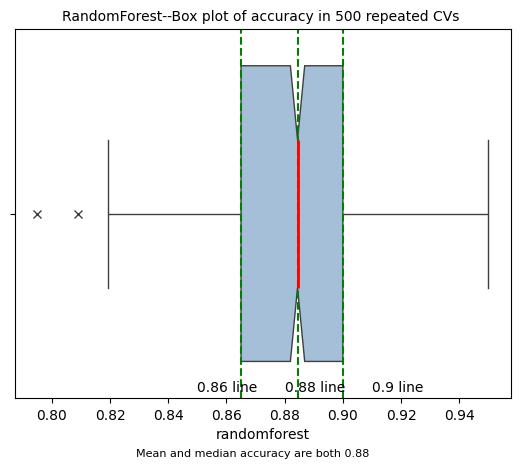

In [57]:
# Accuracy box plot. How accuracy varies over CV trials (randomforest)
_=plt.title("RandomForest--Box plot of accuracy in 500 repeated CVs ",
            ha="center",
            fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="randomforest",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )

pts = np.quantile(acc_array['randomforest'], [0.25,0.5,0.75])

_=ax.axvline(x=pts[0], color='g', linestyle='--')
_=ax.axvline(x=pts[1], color='g', linestyle='--')
_=ax.axvline(x=pts[2], color='g', linestyle='--')  # 75% obs above this line

_=ax.text(0.85,0.48, f"{np.round(pts[0],2)} line")
_=ax.text(0.88,0.48, f"{np.round(pts[1],2)} line")
_=ax.text(0.91,0.48, f"{np.round(pts[2],2)} line")

_=plt.figtext(0.5, -0.01, f"Mean and median accuracy are both {np.round(pts[1],2)} ",
              ha="center",
              fontsize=8)
_=plt.show()

#### precision/recall/f1 scores (randomforest modeling)

In [58]:
# Classification scores (randomforest)
classification_scores = np.array(total_class0)

# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]
# Store the resulting output in pandas Dataframe
classification_array=pd.DataFrame()
classification_array['randomforest'] = res

# 'Explode' the list into columns
classwise_classification_scores = classification_array['randomforest'].apply(pd.Series)

# Rename the columns
classwise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{classwise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{classwise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.897386
recall        0.848030
f1-score      0.870963
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.039517
recall       0.049814
f1-score     0.034320
support      0.400401
dtype: float64


#### precision/recall/f1 scores distribution plots

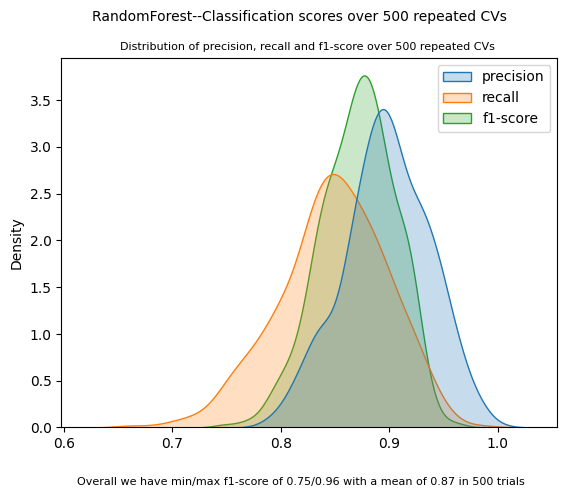

In [59]:
# Classification score distribution plots--500 in 500 repeated CVs (randoforest)
_=sns.kdeplot(classwise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("RandomForest--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(classwise_classification_scores['f1-score'].min(),2)
f1_max = np.round(classwise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(classwise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

### HistGradientBoostingClassifier

#### Hyperparameter search

In [60]:
%%time

# Hyperparameter search Takes 20minutes

hist_classifier = HistGradientBoostingClassifier(
                                                 categorical_features = cat_features,
                                                 loss = 'log_loss',
                                                 )


param_grid = {
              "learning_rate": [0.01, 0.05, 0.1, 0.15],
              "min_samples_leaf": [15,20, 22,25,30],
              "max_leaf_nodes": [7, 10, 15, 20,25,30,35, 40,45],
              "l2_regularization": loguniform(1e-4, 1e-2),
              "max_features" : [0.5,0.6,0.7,0.8,0.9,1],
              "max_iter"     : [150,200,250,300,350]
             }

# Takes time
model_random_search = RandomizedSearchCV(hist_classifier,
                                         param_distributions=param_grid,
                                         n_jobs=-1,
                                         n_iter = 200, # 200 points search. Takes time
                                         cv=5          # For each point, 5-fold evaluation
                                       )


model_random_search.fit(X_train, y_train)
hist_bst_param= model_random_search.best_params_
hist_bst_param


CPU times: user 11.7 s, sys: 2.24 s, total: 13.9 s
Wall time: 19min 35s


{'l2_regularization': np.float64(0.00421084056978826),
 'learning_rate': 0.1,
 'max_features': 0.9,
 'max_iter': 150,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 15}

Best Parameters:       
"""     
{'min_samples_leaf': 15,    
 'max_leaf_nodes': 30,    
 'max_iter': 250,       
 'max_features': 0.7,      
 'learning_rate': 0.15,       
 'l2_regularization': 0.002}  

{'l2_regularization': np.float64(0.0008610172655089705),     
 'learning_rate': 0.15,      
 'max_features': 0.6,     
 'max_iter': 250,    
 'max_leaf_nodes': 35,    
 'min_samples_leaf': 20}    

{'l2_regularization': np.float64(0.0008536867093147364),    
 'learning_rate': 0.1,    
 'max_features': 0.9,    
 'max_iter': 300,    
 'max_leaf_nodes': 40,    
 'min_samples_leaf': 20}          


"""

In [62]:
%%time

# Ref: https://stackoverflow.com/a/66022487

clf = HistGradientBoostingClassifier(max_iter=hist_bst_param['max_iter'],
                                                 max_leaf_nodes=  hist_bst_param['max_leaf_nodes'],
                                                 min_samples_leaf = hist_bst_param['min_samples_leaf'],
                                                 l2_regularization = hist_bst_param['l2_regularization'],
                                                 categorical_features = cat_features,
                                                 learning_rate = hist_bst_param['learning_rate'],
                                                 max_features = hist_bst_param['max_features'],
                                                 #class_weight = 'balanced'
                                                 )


# Store (cormack lehane) classwise classification-report
# over all 100 repeated 5-fold n_splits:
total_class0 = []  # [class0] * 100
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *100]
total_class2 = []  # [class2] * 100
total_class3 = []  # [class3] * 100
# To store, class-wise roc-data, for 100 attempts
all_roc_auc = []
# To store accuracy data for 100 attempts
total_acc_list = []
count = 1

print("==******************************************" )
print("Total number of folds would be: 100 X 5 = 500" )
print("==******************************************\n\n" )

# We take 5-random folds 100 times
for i in range(100):
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)

  # Iterate 5-times ie once per split
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # Get accuracy in this particular split (averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # Get class-wise AUC scores:
      auc = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr',
                          average = None)
      print("Class-wise AUC for this fold/split:", auc)
      list_roc_auc.append(auc) # One-vs-rest auc
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")

hist_classifier = clf


==******************************************
Total number of folds would be: 100 X 5 = 500
==******************************************


fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.885
Class-wise AUC for this fold/split: [0.97698006 0.96895292 0.98743207 0.99555885]
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.885
Class-wise AUC for this fold/split: [0.97403493 0.92593344 0.96560591 0.70392302]
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy for this fold/split averaged over all the classes: 0.865
Class-wise AUC for this fold/split: [0.96148148 0.95090596 0.98649952 0.99777942]
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy for this 

In [63]:
# Just check shapes of our data collectors
# n_splits: 5
# Repeated n_splits:100
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (100, 5, 4)
# AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (100, 5, 4)
# Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (100,5)

(5, 4)

(100, 5, 4)

(5, 4)

(100, 5, 4)

(5,)

(100, 5)

#### AUC scores (histclassifier modeling)

In [64]:
# AUC data compilation (histclassifier)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("HistClassifier--Class-wise mean of AUCs    :" ,all_roc_auc_array.reshape(500,4).mean(axis=0))
# Class-wise std dev of AUCs
print("HistClassifier--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(500,4).std(axis=0))


(100, 5, 4)

HistClassifier--Class-wise mean of AUCs    : [0.95544625 0.9436617  0.94732773 0.97133309]
HistClassifier--Class-wise std devs of AUCs: [0.01805693 0.01957845 0.05032638 0.06867399]


#### AUC distribution plot (HistClassifier)

In [65]:
# Classwise AUCs in 500 iterations (histclassifier)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['histclassifier'] = res
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['histclassifier'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
print("              Class-wise AUCs")
classwise_roc.head()

              Class-wise AUCs


,class1,class2,class3,class4
0,0.976980,0.968953,0.987432,0.995559
1,0.974035,0.925933,0.965606,0.703923
2,0.961481,0.950906,0.986500,0.997779
3,0.951665,0.949120,0.907240,1.000000
4,0.972445,0.961712,0.972527,1.000000


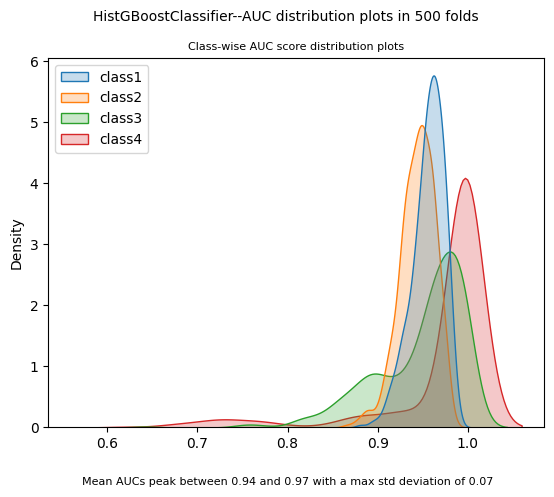

In [66]:
# AUC distribution plots--500 folds (histclassifier)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("HistGBoostClassifier--AUC distribution plots in 500 folds ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
min = np.round(np.min(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
max = np.round(np.max(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
maxsd = np.round(np.max(all_roc_auc_array.reshape(500,4).std(axis=0)),2)
_=plt.figtext(0.5, -0.01, f"Mean AUCs peak between {min} and {max} with a max std deviation of {maxsd}",
              ha="center",
              fontsize=8)
_=plt.show()

#### Accuracy distribution (histclassifier)


In [67]:
# Mean accuracy scores over CV trials (extratrees)
print("===HistClassifier=====")
acc_array['histclassifier'] = np.array(total_acc_list).flatten()
print("Mean Accuracy                  :", np.mean(acc_array['histclassifier']))
print("Median Accuracy                :", np.median(acc_array['histclassifier']))
print("Std deviation of accuracy      :", np.std(acc_array['histclassifier']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(500,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(500,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

===HistClassifier=====
Mean Accuracy                  : 0.8835625628140703
Median Accuracy                : 0.8844221105527639
Std deviation of accuracy      : 0.024450091683803188
Class-wise avg AUC score       : [0.95544625 0.9436617  0.94732773 0.97133309]
Class-wise avg std dev of AUCs : [0.01805693 0.01957845 0.05032638 0.06867399]
(for classes 1,2,3,4 respectively)


#### Distribution plot for accuracy (HistClassifier)

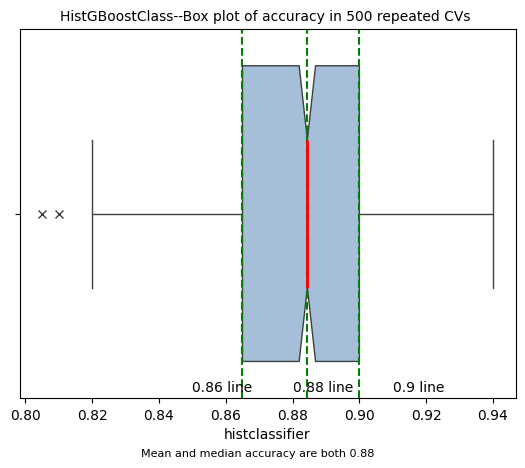

In [68]:
# Accuracy box plot. How accuracy varies over CV trials (randomforest)
_=plt.title("HistGBoostClass--Box plot of accuracy in 500 repeated CVs ",
            ha="center",
            fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="histclassifier",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )

pts = np.quantile(acc_array['histclassifier'], [0.25,0.5,0.75])

_=ax.axvline(x=pts[0], color='g', linestyle='--')
_=ax.axvline(x=pts[1], color='g', linestyle='--')
_=ax.axvline(x=pts[2], color='g', linestyle='--')  # 75% obs above this line

_=ax.text(0.85,0.48, f"{np.round(pts[0],2)} line")
_=ax.text(0.88,0.48, f"{np.round(pts[1],2)} line")
_=ax.text(0.91,0.48, f"{np.round(pts[2],2)} line")

_=plt.figtext(0.5, -0.01, f"Mean and median accuracy are both {np.round(pts[1],2)} ",
              ha="center",
              fontsize=8)
_=plt.show()

#### precision/recall/f1 scores (HistClassifier modeling)

In [69]:
# Classification scores (extratrees)
classification_scores = np.array(total_class0)

# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]
# Store the resulting output in pandas Dataframe
classification_array=pd.DataFrame()
classification_array['histclassifier'] = res

# 'Explode' the list into columns
classwise_classification_scores = classification_array['histclassifier'].apply(pd.Series)

# Rename the columns
classwise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{classwise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{classwise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.875568
recall        0.852757
f1-score      0.862777
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.042937
recall       0.049295
f1-score     0.033341
support      0.400401
dtype: float64


#### precision/recall/f1 scores distribution plots (histclassifier)

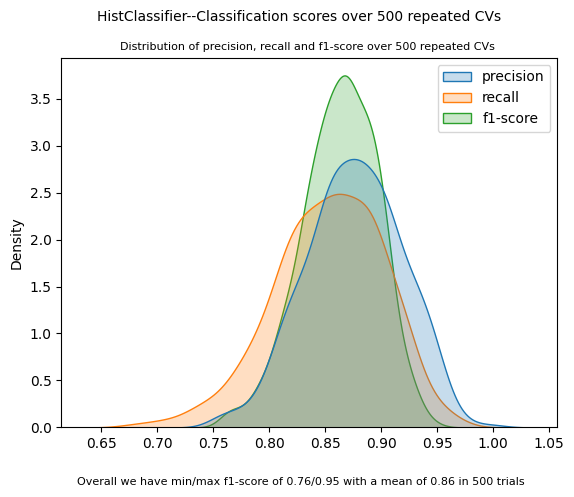

In [70]:
# Classification score distribution plots--500 in 500 repeated CVs (randoforest)
_=sns.kdeplot(classwise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("HistClassifier--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(classwise_classification_scores['f1-score'].min(),2)
f1_max = np.round(classwise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(classwise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

## ExtraTrees

In [ ]:
%%time

# Ref: https://stackoverflow.com/a/66022487

clf = ExtraTreesClassifier(criterion="entropy",
                           n_estimators=400,
                           max_depth=None,
                           min_samples_split=2,
                           )

# Store (cormack lehane) classwise classification-report
# over all 100 repeated 5-fold n_splits:
total_class0 = []  # [class0] * 100
total_class1 = []  # [[['precision', 'recall', 'f1-score', 'support'] * n_splits ] *100]
total_class2 = []  # [class2] * 100
total_class3 = []  # [class3] * 100
# To store, class-wise roc-data, for 100 attempts
all_roc_auc = []
# To store accuracy data for 100 attempts
total_acc_list = []
count = 1

print("==******************************************" )
print("Total number of folds would be: 100 X 5 = 500" )
print("==******************************************\n\n" )

# We take 5-random folds 100 times
for i in range(100):
  # To store accuracy data averaged over all classes
  list_accu_stratified = []
  # Class-wise roc-data for each of the classes for five folds
  list_roc_auc = []
  # Classwise classification report per cross-validation
  class0 = []  # class0: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class1 = []  # class1: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class2 = []  # class2: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  class3 = []  # class3: [['precision', 'recall', 'f1-score', 'support'] * n_splits ]
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)

  # Iterate 5-times ie once per split
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]  # y is label encoded
      print("=======")
      print("fold:", count ) ; count = count +1
      if (i < 1):
        print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Use X_train, X_test, y_train, y_test to train/evaluate model in each fold
      clf.fit(X_train, y_train)

      # Get accuracy in this particular split (averaged over all classes)
      acc = clf.score(X_test, y_test)
      print("Accuracy for this fold/split averaged over all the classes:", acc)
      list_accu_stratified.append(acc)

      # Get class-wise AUC scores:
      auc = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr',
                          average = None)
      print("Class-wise AUC for this fold/split:", auc)
      list_roc_auc.append(auc) # One-vs-rest auc
      sk = classification_report(y_test,
                                 clf.predict(X_test),
                                 output_dict = True  # dict format and not tabular format
                                 )
      # sk['0'].values(): ['precision', 'recall', 'f1-score', 'support']
      #                   for class-0 of cormack lehane
      class0.append(list(sk['0'].values()))
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)
  print(f"Mean accuracy over {i+1}-n_splits of 5-folds each : {np.mean(np.array(total_acc_list).flatten())}")

extra_classifier = clf

fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.905
Class-wise AUC: [0.98433048 0.98229505 0.97707201 0.98519615]
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.885
Class-wise AUC: [0.9765625  0.96438718 0.96994536 0.99703923]
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.915
Class-wise AUC: [0.94786325 0.94948881 0.99871424 1.        ]
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.9346733668341709
Class-wise AUC: [0.97456946 0.97379197 0.99531351 1.        ]
fold: 5
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.9095477386934674
Class-wise AUC: [0.97416762 0.96432228 0.96622495 0.99913644]
fold: 6
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_tes

In [ ]:
# Just check shapes of our data collectors
# n_splits: 5
# Repeated n_splits:100
# No of classes: 4
# No of classification scores: 4 (precision/recall/f1/support)

# Classification reports
np.array(class0).shape                 # (5x4)       [For everyone of n_splits, one report]
np.array(total_class0).shape           # (100, 5, 4)
# AUC
np.array(list_roc_auc).shape           # (5X4)       [For everyone of n_splits, AUC over all 4 classes]
np.array(all_roc_auc).shape            # (100, 5, 4)
# Accuracy
np.array(list_accu_stratified).shape   # (5,)        [Mean accuracy over every one of n_splits]
np.array(total_acc_list).shape         # (100,5)

(5, 4)

(100, 5, 4)

(5, 4)

(100, 5, 4)

(5,)

(100, 5)

### AUC scores (ExtraTrees modeling)

In [ ]:
# AUC data compilation (extratrees)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("ExtraTrees--Class-wise mean of AUCs:    " ,all_roc_auc_array.reshape(500,4).mean(axis=0))
# Class-wise std dev of AUCs
print("ExtraTrees--Class-wise std devs of AUCs:" ,all_roc_auc_array.reshape(500,4).std(axis=0))

(100, 5, 4)

ExtraTrees--Class-wise mean of AUCs:     [0.96904571 0.96272055 0.97692975 0.98905305]
ExtraTrees--Class-wise std devs of AUCs: [0.01383517 0.01326817 0.02577767 0.03078377]


### AUC distribution plot (extratrees modeling)

In [ ]:
# Classwise AUCs in 500 iterations (extratrees)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['extratrees'] = res
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['extratrees'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
print("              Class-wise AUCs")
classwise_roc.head()

              Class-wise AUCs


,class1,class2,class3,class4
0,0.984330,0.982295,0.977072,0.985196
1,0.976562,0.964387,0.969945,0.997039
2,0.947863,0.949489,0.998714,1.000000
3,0.974569,0.973792,0.995314,1.000000
4,0.974168,0.964322,0.966225,0.999136


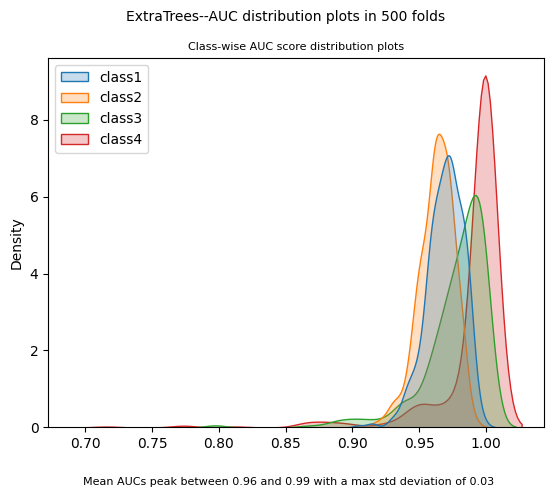

In [ ]:
# AUC distribution plots--500 folds (Extratrees)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("ExtraTrees--AUC distribution plots in 500 folds ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
min = np.round(np.min(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
max = np.round(np.max(all_roc_auc_array.reshape(500,4).mean(axis=0)),2)
maxsd = np.round(np.max(all_roc_auc_array.reshape(500,4).std(axis=0)),2)
_=plt.figtext(0.5, -0.01, f"Mean AUCs peak between {min} and {max} with a max std deviation of {maxsd}",
              ha="center",
              fontsize=8)
_=plt.show()

### Accuracy distribution (extratrees)


In [ ]:
# Mean accuracy scores over CV trials (extratrees)
print("===ExtraTrees=====")
acc_array['extratrees'] = np.array(total_acc_list).flatten()
print("Mean Accuracy                  :", np.mean(acc_array['extratrees']))
print("Median Accuracy                :", np.median(acc_array['extratrees']))
print("Std deviation of accuracy      :", np.std(acc_array['extratrees']))
print("Class-wise avg AUC score       :", all_roc_auc_array.reshape(500,4).mean(axis=0))
print("Class-wise avg std dev of AUCs :", all_roc_auc_array.reshape(500,4).std(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

===ExtraTrees=====
Mean Accuracy                  : 0.9094507537688441
Median Accuracy                : 0.91
Std deviation of accuracy      : 0.021211046174961935
Class-wise avg AUC score       : [0.96904571 0.96272055 0.97692975 0.98905305]
Class-wise avg std dev of AUCs : [0.01383517 0.01326817 0.02577767 0.03078377]
(for classes 1,2,3,4 respectively)


### Distribution plot for accuracy (ExtraTrees)


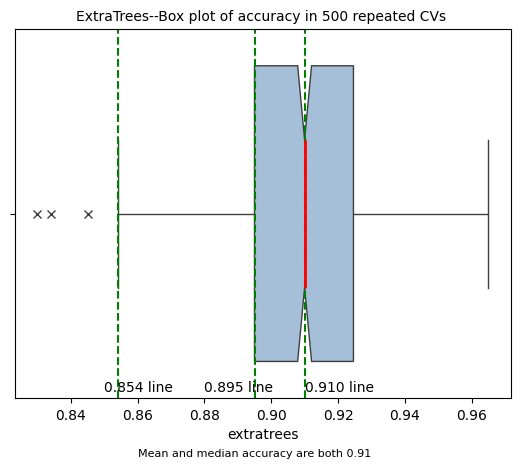

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (extratrees)
_=plt.title("ExtraTrees--Box plot of accuracy in 500 repeated CVs ", ha="center", fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="extratrees",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )

pts = np.quantile(acc_array['extratrees'], [0.25,0.5,0.75])

_=ax.axvline(x=pts[0], color='g', linestyle='--')
_=ax.axvline(x=pts[1], color='g', linestyle='--')
_=ax.axvline(x=pts[2], color='g', linestyle='--')  # 75% obs above this line

_=ax.text(0.85,0.48, f"{np.round(pts[0],2)} line")
_=ax.text(0.88,0.48, f"{np.round(pts[1],2)} line")
_=ax.text(0.91,0.48, f"{np.round(pts[2],2)} line")

_=plt.figtext(0.5, -0.01, f"Mean and median accuracy are both {np.round(pts[1],2)} ",
              ha="center",
              fontsize=8)
_=plt.show()

### precision/recall/f1 scores (ExtraTrees modeling)

In [ ]:
# Classification scores (extratrees)
classification_scores = np.array(total_class0)

# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]
# Store the resulting output in pandas Dataframe
classification_array=pd.DataFrame()
classification_array['extratrees'] = res

# 'Explode' the list into columns
classwise_classification_scores = classification_array['extratrees'].apply(pd.Series)

# Rename the columns
classwise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
print("======")
print(f"Mean classification scores\n\n{classwise_classification_scores.mean()}")
print("======")
print("")
print(f"Std Dev of classification scores\n\n{classwise_classification_scores.std()}")
print("======")


Mean classification scores

precision     0.901669
recall        0.885770
f1-score      0.892669
support      64.800000
dtype: float64

Std Dev of classification scores

precision    0.037908
recall       0.045582
f1-score     0.030075
support      0.400401
dtype: float64


### precision/recall/f1 scores distribution plots (extratrees)

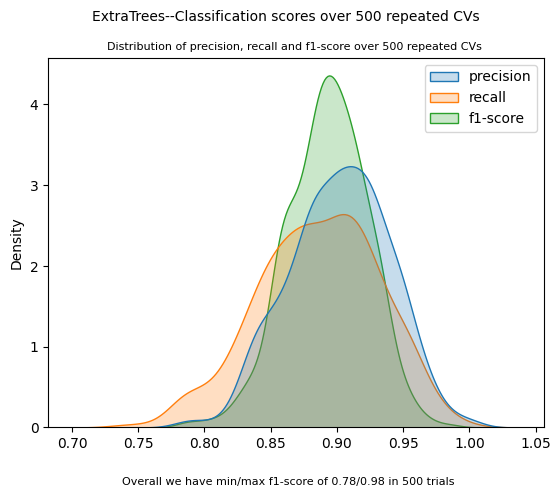

In [ ]:
# Classification score distribution plots--500 in 500 repeated CVs (randoforest)
_=sns.kdeplot(classwise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("ExtraTrees--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
f1_min = np.round(classwise_classification_scores['f1-score'].min(),2)
f1_max = np.round(classwise_classification_scores['f1-score'].max(),2)
f1_mean= np.round(classwise_classification_scores['f1-score'].mean(),2)
_=plt.figtext(0.5, -0.01, f"Overall we have min/max f1-score of {f1_min}/{f1_max} with a mean of {f1_mean} in 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

## Permutation feature importance
Refer [here](https://scikit-learn.org/stable/modules/permutation_importance.html) AND [here](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

Given a model, permutation feature importance measures the importance of a feature viz-a-viz others in acheievong certyain performance level..

Permutation feature importance (PFI) is a model-agnostic technique used to assess the contribution of individual features to a machine learning model's predictive performance. Here's a structured breakdown:

---

## **Core Concept**  
PFI measures how much a model's performance degrades when a specific feature's values are randomly shuffled, breaking its relationship with the target variable. A larger performance drop indicates higher importance for that feature[2][6].

---

## **Key Steps**  
1. **Train the model** and evaluate its baseline performance (e.g., accuracy, RMSE) on a held-out dataset[2][5].  
2. **Shuffle one feature** while keeping others unchanged, then recompute performance[4].  
3. **Compare performance** between the original and shuffled scenarios to calculate importance, either as a difference ($$FI_j = e_{perm,j} - e_{orig}$$) or ratio ($$FI_j = e_{perm,j}/e_{orig}$$)[2][6].  
4. **Repeat** for all features and multiple permutations to reduce variance[1][4].

---

## **When to Use**  
- **Model interpretability**: Especially useful for non-linear or opaque models (e.g., random forests, neural networks)[1][4].  
- **Feature selection**: Identifies features critical for generalization when evaluated on a validation set[1][5].  
- **Data insights**: Reveals whether a model relies on meaningful patterns or noise (e.g., random features should show low importance)[2][5].

---

## **Advantages**  
- **Model-agnostic**: Works with any supervised learning algorithm[1][2].  
- **Interaction-aware**: Captures both main effects and feature interactions without retraining[2][6].  
- **Computationally efficient**: No need to refit models, unlike wrapper methods[2][7].

---

## **Limitations**  
- **Dataset-dependent**: Importance scores reflect a specific model-dataset pairing, not intrinsic feature value[1][4].  
- **Overfitting risk**: Features important on training data but not validation data may indicate overfitting[1][5].  
- **Correlation effects**: Importance of correlated features may be split, reducing their individual scores[2][6].

---

## **Implementation Tips**  
- **Use held-out data**: Compute importance on validation/test sets to assess generalization[1][5].  
- **Repeat permutations**: Set `n_repeats` (e.g., 10-100) to estimate variance and improve reliability[1][4].  
- **Avoid low-quality models**: PFI for poorly performing models can be misleading, as all features may appear unimportant[4][5].

---

PFI is widely supported in libraries like scikit-learn (via `permutation_importance`) and Azure ML, making it accessible for practical workflows[1][5][7].

Citations:
[1] https://scikit-learn.org/stable/modules/permutation_importance.html
[2] https://christophm.github.io/interpretable-ml-book/feature-importance.html
[3] https://www.kaggle.com/code/dansbecker/permutation-importance
[4] https://scikit-learn.org/0.24/modules/permutation_importance.html
[5] https://learn.microsoft.com/en-us/azure/machine-learning/component-reference/permutation-feature-importance?view=azureml-api-2
[6] https://www.aporia.com/learn/feature-importance/explain-ml-models-with-permutation-importance/
[7] https://mindfulmodeler.substack.com/p/how-to-implement-permutation-feature

---
Answer from Perplexity: https://www.perplexity.ai/search/tell-me-about-permutation-feat-TgBNixj8Rl6P_iXY7Fz8lQ?utm_source=copy_output

In [ ]:
# Splitting the dataset into test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Our model
clf = ExtraTreesClassifier(criterion="entropy",
                           n_estimators=400,
                           max_depth=None,
                           min_samples_split=2,
                           )
clf.fit(X_train, y_train)

# Calculate permutation importance with test data
# We permute each feature 40 times
etr = permutation_importance(clf, X_test, y_test,
                             n_repeats=40)




ExtraTreesClassifier(criterion='entropy', n_estimators=400)

In [ ]:
# Data collectors
# Feature names
cols = []
# Feature impt
etr_mean = []
# Feature impt std dev
etr_std = []

print("Extent of degradation of accuracy score")
print("=======================================\n")
for i in etr.importances_mean.argsort()[::-1]:
    if etr.importances_mean[i] - 2 * etr.importances_std[i] > 0:
        print(f"{df.columns[i]:<13}\t\t\t"
              f"{etr.importances_mean[i]:.3f}"
              f" +/- {etr.importances_std[i]:.3f}")
        cols.append(df.columns[i])
        etr_mean.append(np.round(etr.importances_mean[i],2))
        etr_std.append(np.round(etr.importances_std[i],2))
print("===============")

Extent of degradation of accuracy score

mallampatti  			0.187 +/- 0.023
age          			0.105 +/- 0.020
bmi          			0.097 +/- 0.014
sex          			0.097 +/- 0.020
thyromental distance			0.095 +/- 0.017
buck teeth   			0.081 +/- 0.014
height       			0.079 +/- 0.014
sternomental distance			0.071 +/- 0.013
edentulous   			0.050 +/- 0.013
head and neck movement			0.047 +/- 0.011
subluxation of mandible			0.045 +/- 0.014


In [ ]:
# Tabulate above results
# Ref: https://pypi.org/project/tabulate/
from tabulate import tabulate
table = [cols, etr_mean, etr_std]
print("                                                       Extent of degradation of accuracy score")
print(tabulate(table, showindex = ["cols=>", "mean", "std"], tablefmt = 'grid'))

                                                       Extent of degradation of accuracy score
+--------+-------------+------+------+------+----------------------+------------+--------+-----------------------+------------+------------------------+-------------------------+
| cols=> | mallampatti | age  | bmi  | sex  | thyromental distance | buck teeth | height | sternomental distance | edentulous | head and neck movement | subluxation of mandible |
+--------+-------------+------+------+------+----------------------+------------+--------+-----------------------+------------+------------------------+-------------------------+
| mean   | 0.19        | 0.11 | 0.1  | 0.1  | 0.09                 | 0.08       | 0.08   | 0.07                  | 0.05       | 0.05                   | 0.05                    |
+--------+-------------+------+------+------+----------------------+------------+--------+-----------------------+------------+------------------------+-------------------------+
| std    |

In [ ]:
# Plot function for permutation importance
# Ref: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

def plot_permutation_importance(etr, X, y, ax):
    perm_sorted_idx = etr.importances_mean.argsort()
    tick_labels_dict = {"tick_labels": X.columns[perm_sorted_idx]}
    ax.boxplot(etr.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

<Axes: >

<Axes: >

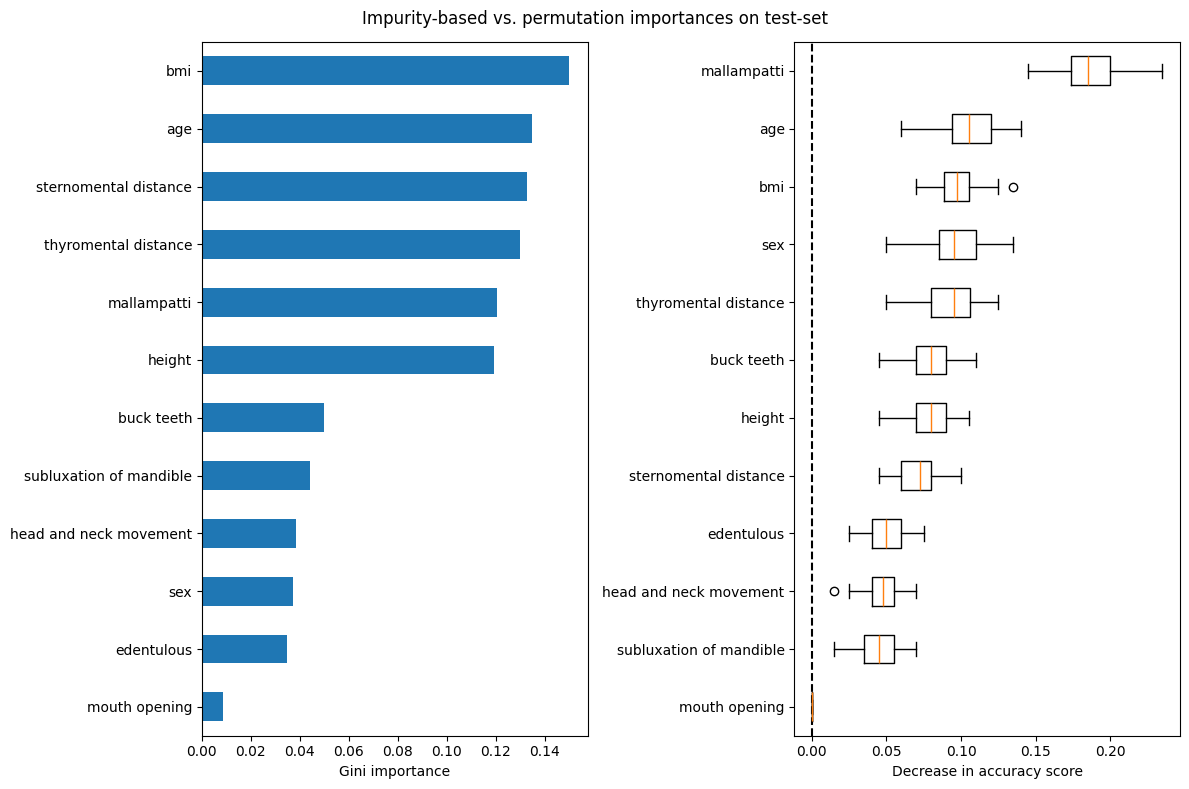

In [ ]:
# Plot impurity based and permutaion based importances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Impurity based importance plot
mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
mdi_importances.sort_values().plot.barh(ax=ax1)
_=ax1.set_xlabel("Gini importance")

# Permutation importance plot
plot_permutation_importance(etr, X_test, y_test, ax2)
_=ax2.set_xlabel("Decrease in accuracy score")

_=fig.suptitle(
    "Impurity-based vs. permutation importances on test-set"
)
_ = fig.tight_layout()

## XGBoost classifier

### Hyperparameter search

In [ ]:
%%time

# Took 30 minutes
# Search for the best xgboost parameters using Randomized cv search
from sklearn.metrics import accuracy_score
xgb_classifier = XGBClassifier(
                                objective='binary:logistic',
                                eval_metric = accuracy_score,
                                n_jobs = 16
                               )

# Consider these parameters:
param_grid = {
              "booster" : ['gbtree', 'dart', 'gblinear'],
              "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
              "n_estimators" : [200, 250,300,350],
              "max_depth" : [3,4,5,6,7,8,9],
              "grow_policy" : ['depthwise', 'lossguide'],
              "colsample_bytree" : [0.5,0.7,0.9,1.0],
              "reg_lambda": loguniform(1e-4, 1e-2),
              "reg_alpha" : loguniform(1e-4, 1e-2),
              "gamma" : loguniform(1e-4, 1e-2),
             }

# Evaluate over 100 points in the search space
# Best fitted model is returned
model_random_search = RandomizedSearchCV(xgb_classifier,
                                         param_distributions=param_grid,
                                         n_jobs=-1,
                                         n_iter = 100,  # Look at 100 pts
                                         cv=5
                                        )


model_random_search.fit(X_train, y_train)
xgb_bst_param= model_random_search.best_params_
xgb_bst_param


CPU times: user 48.8 s, sys: 3.93 s, total: 52.7 s
Wall time: 42min 7s


{'booster': 'dart',
 'colsample_bytree': 0.5,
 'gamma': np.float64(0.0034610752394487725),
 'grow_policy': 'depthwise',
 'learning_rate': 0.2,
 'max_depth': 8,
 'n_estimators': 200,
 'reg_alpha': np.float64(0.0003584127720728602),
 'reg_lambda': np.float64(0.002922484172354949)}

In [ ]:
# Best fitted model's performance:
model_random_search.score(X_test,y_test)  # 0.8592964824120602

0.8542713567839196

Here are the hyperparameter values:     
"""       
CPU times: user 48.8 s, sys: 3.93 s, total: 52.7 s     
Wall time: 42min 7s     

{'booster': 'dart',     
 'colsample_bytree': 0.5,     
 'gamma': np.float64(0.0034610752394487725),    
 'grow_policy': 'depthwise',      
 'learning_rate': 0.2,     
 'max_depth': 8,          
 'n_estimators': 200,        
 'reg_alpha': np.float64(0.0003584127720728602),       
 'reg_lambda': np.float64(0.002922484172354949)}       


booster = 'dart',    
colsample_bytree =  0.5,    
gamma = np.float64(0.0034610752394487725),    
grow_policy = 'depthwise',    
learning_rate = 0.2,   
max_depth = 8,   
n_estimators = 200,   
reg_alpha = np.float64(0.0003584127720728602),  
reg_lambda = np.float64(0.002922484172354949)   


"""

### Using the hyperparameters in StratifiedKFold

In [ ]:
%%time
# The accuracy with the best parameters:

skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=42)

xgb_clf = XGBClassifier(booster = xgb_bst_param['booster'],
                        max_depth = xgb_bst_param['max_depth'],
                        n_estimators=xgb_bst_param['n_estimators'],
                        grow_policy = xgb_bst_param['grow_policy'],
                        colsample_bytree = xgb_bst_param['colsample_bytree'],
                        reg_lambda = xgb_bst_param['reg_lambda'],
                        reg_alpha = xgb_bst_param['reg_alpha'],
                        gamma =xgb_bst_param['gamma'],
                        learning_rate= xgb_bst_param['learning_rate'],
                        objective='binary:logistic',
                        )


list_accu_stratified = []
count = 1
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("=======")
    print("fold:", count ) ; count = count +1
    print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
    # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
    xgb_clf.fit(X_train, y_train)
    print("Accuracy:", xgb_clf.score(X_test, y_test))
    list_accu_stratified.append(xgb_clf.score(X_test, y_test))
    auc = roc_auc_score(y_test,
                          xgb_clf.predict_proba(X_test),
                          multi_class='ovr',
                          average = None)
    print("Class-wise AUC:", auc)

print("========")
print("Overall Accuracy:", np.mean(list_accu_stratified))
print("========")


fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.88
Class-wise AUC: [0.95088319 0.93689123 0.95142663 0.99629904]
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.895
Class-wise AUC: [0.96863511 0.96530032 0.99292832 0.9903775 ]
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.885
Class-wise AUC: [0.96022792 0.94422512 0.88331726 0.99703923]
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.8944723618090452
Class-wise AUC: [0.93168772 0.93560606 0.95927602 1.        ]
fold: 5
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.864321608040201
Class-wise AUC: [0.93318025 0.9296683  0.90659341 1.        ]
Overall Accuracy: 0.8837587939698492
CPU times: user 2min 24s, sys: 735 ms, total: 2mi

## ======== END ================

## Rough Work
Below is rough work of algorithms that have been tried. Can be ignored.

### Repeated StratifiedKFold
But with [catboost encoder](https://contrib.scikit-learn.org/category_encoders/catboost.html) and alse see [here](https://contrib.scikit-learn.org/category_encoders/index.html)

In [ ]:
!pip install category_encoders -q

In [ ]:
%%time
import category_encoders as ce
clf = ExtraTreesClassifier(criterion = "log_loss",
                           n_estimators=400,
                           max_depth=None,
                           min_samples_split=2,
                           #class_weight = 'balanced',
                           #ccp_alpha = 0.0005
                           )

total_class0 = []
total_class1 = []
total_class2 = []
total_class3 = []
all_roc_auc  = []
total_acc_list = []
count = 1
for i in range(100):
  list_accu_stratified = []
  list_roc_auc = []
  class0  = []    # [['precision', 'recall', 'f1-score', 'support'] ....]
  class1 = []
  class2 = []
  class3 = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True,
                        random_state = None
                        )
  #count = 1
  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]   # y is label encoded
      encoder = ce.CatBoostEncoder(cols=["sex", "edentulous",
                                         "mouth opening", "head and neck movement"]
                                   )
      encoder.fit(X_train, y_train)
      X_train = encoder.transform(X_train)
      X_test = encoder.transform(X_test)
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      clf.fit(X_train, y_train)
      acc = clf.score(X_test, y_test)
      print("Accuracy:", acc)
      list_accu_stratified.append(acc)
      auc = roc_auc_score(y_test,
                          clf.predict_proba(X_test),
                          multi_class='ovr',
                          average = None)
      print("Class-wise AUC:", auc)
      list_roc_auc.append(auc) # One-vs-rest auc
      sk = classification_report(y_test, clf.predict(X_test), output_dict = True)
      class0.append(list(sk['0'].values()))  # [['precision', 'recall', 'f1-score', 'support']...]
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)
  all_roc_auc.append(list_roc_auc)


fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.88
Class-wise AUC: [0.96934473 0.96377841 0.99490489 0.99851962]
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.9
Class-wise AUC: [0.96065028 0.95058847 0.97332048 0.99851962]
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.92
Class-wise AUC: [0.96364672 0.96522927 0.99614272 1.        ]
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.9095477386934674
Class-wise AUC: [0.96515499 0.95679771 0.99450549 1.        ]
fold: 5
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.9547738693467337
Class-wise AUC: [0.97726751 0.97292179 0.98691015 1.        ]
fold: 6
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test sh

In [ ]:
# AUC data compilation (extratrees_catboost_enc)
all_roc_auc_array = np.array(all_roc_auc)
all_roc_auc_array.shape
# Class-wise mean of AUCs
print("ExtraTrees-catencoded--Class-wise mean of AUCs:" ,all_roc_auc_array.mean(axis=0).mean(axis=0))

(100, 5, 4)

Class-wise mean of AUCs: [0.96894044 0.96209302 0.97599309 0.98861535]


In [ ]:
# Classwise AUCs in 500 iterations (extratrees_catboost_enc)
# Unlist the list
res =  [x for sublist in all_roc_auc for x in sublist]
# Store the resulting output in pandas Dataframe
roc_array['extratrees_catboost_enc'] = res
# 'Explode' the list into class-wise columns
classwise_roc = roc_array['extratrees_catboost_enc'].apply(pd.Series)
# Rename the columns
classwise_roc.columns = ['class1', 'class2', 'class3', 'class4']
classwise_roc.head()

,class1,class2,class3,class4
0,0.969345,0.963778,0.994905,0.99852
1,0.960650,0.950588,0.973320,0.99852
2,0.963647,0.965229,0.996143,1.00000
3,0.965155,0.956798,0.994505,1.00000
4,0.977268,0.972922,0.986910,1.00000


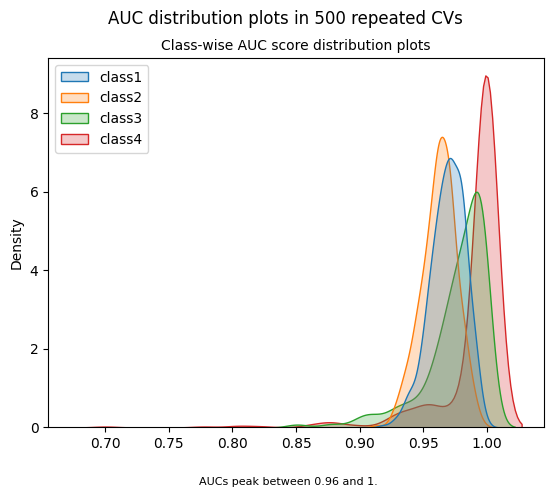

In [ ]:
# AUC distribution plots--500 in 500 repeated CVs (extratrees_catboost_enc)
_=sns.kdeplot(classwise_roc, fill=True)
_=plt.suptitle("ExtraTrees-catencoded--AUC distribution plots in 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Class-wise AUC score distribution plots", ha="center", fontsize=8)
_=plt.figtext(0.5, -0.01, "AUCs peak between 0.96 and 1.",
              ha="center",
              fontsize=8)
_=plt.show()

In [ ]:
# Mean accuracy scores over CV trials (extratrees_catboost_enc)
print("===ExtraTrees-catencoded--=====")
acc_array['extratrees_catboost_enc'] = np.array(total_acc_list).flatten()
print("Mean Accuracy:", np.mean(acc_array['extratrees_catboost_enc']))
print("Median Accuracy:", np.median(acc_array['extratrees_catboost_enc']))
print("Std deviation of accuracy:", np.std(acc_array['extratrees_catboost_enc']))
print("Class-wise avg AUC scores :", all_roc_auc_array.mean(axis=0).mean(axis=0))
print("(for classes 1,2,3,4 respectively)")
print("========")

Mean Accuracy: 0.9101030150753768
Median Accuracy: 0.91
Std deviation of accuracy: 0.022623969202489443
Class-wise avg AUC scores : [0.96894044 0.96209302 0.97599309 0.98861535]
(for classes 1,2,3,4 respectively)


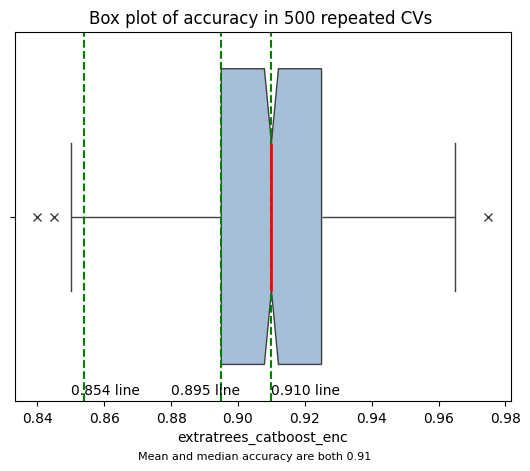

In [ ]:
# Accuracy box plot. How accuracy varies over CV trials (extratrees_catboost_enc)
_=plt.title("ExtraTrees-catencoded--Box plot of accuracy in 500 repeated CVs ", ha="center", fontsize=10)
ax=sns.boxplot(
            data=acc_array, x="extratrees_catboost_enc",
            notch=True, showcaps=True,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )


_=ax.axvline(x=0.854, color='g', linestyle='--')
_=ax.axvline(x=0.91, color='g', linestyle='--')
_=ax.axvline(x=0.895, color='g', linestyle='--')  # 75% obs above this line
_=ax.text(0.88,0.48, "0.895 line")
_=ax.text(0.91,0.48, "0.910 line")
_=ax.text(0.85,0.48, "0.854 line")

_=plt.figtext(0.5, -0.01, "Mean and median accuracy are both 0.91",
              ha="center",
              fontsize=8)
_=plt.show()

In [ ]:
# AUC data compilation (extratrees_catboost_enc)
classification_scores = np.array(total_class0)
# Classwise AUCs in 500 iterations
# Unlist the list
res =  [x for sublist in classification_scores for x in sublist]
# Store the resulting output in pandas Dataframe
classification_array=pd.DataFrame()
classification_array['extraTrees_catboost_enc'] = res
# 'Explode' the list into class-wise columns
classwise_classification_scores = classification_array['extraTrees_catboost_enc'].apply(pd.Series)
# Rename the columns
classwise_classification_scores.columns = ['precision', 'recall', 'f1-score', 'support']
classwise_classification_scores.head(2)


,precision,recall,f1-score,support
0,0.910714,0.784615,0.842975,65.0
1,0.878788,0.906250,0.892308,64.0


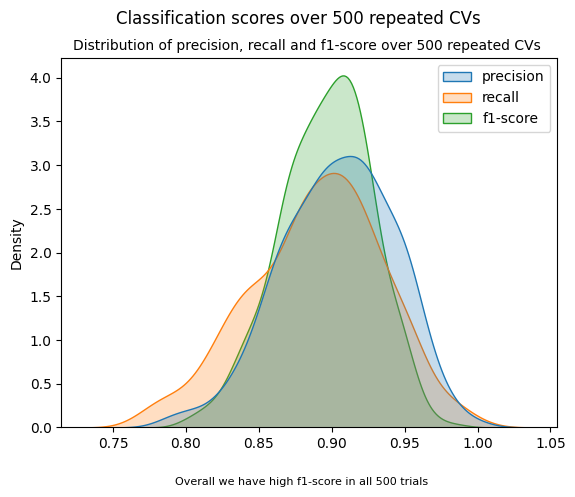

In [ ]:
# AUC distribution plots--500 in 500 repeated CVs (extratrees_catboost_enc)
_=sns.kdeplot(classwise_classification_scores[["precision", 	"recall", 	"f1-score"]], fill=True)
_=plt.suptitle("ExtraTrees-catencoded--Classification scores over 500 repeated CVs ", ha="center", fontsize=10)
_=plt.title("Distribution of precision, recall and f1-score over 500 repeated CVs ", ha="center", fontsize=8)
_=plt.figtext(0.5, -0.01, "Overall we have high f1-score in all 500 trials",
              ha="center",
              fontsize=8)
_=plt.show()

## Comparing two models
 Box plots of accuracy distributions for ExtraTrees vs ExtraTrees-catencoded

In [ ]:
# Prepare dataframes for plotting
df_melted = pd.melt(acc_array[
                               ['extratrees',
                               'extratrees_catboost_enc']
                              ],
                     var_name='Feature',
                     value_name='Value'
                     )
df_melted.head(2)
df_melted.tail(2)

,Feature,Value
0,extratrees,0.90
1,extratrees,0.92


,Feature,Value
998,extratrees_catboost_enc,0.914573
999,extratrees_catboost_enc,0.934673


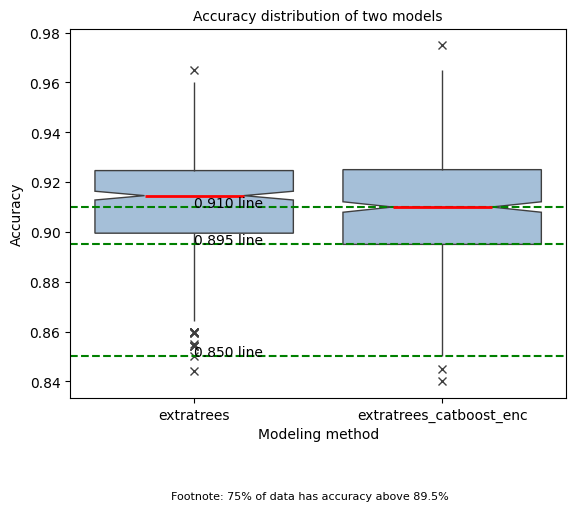

In [ ]:
# Create the boxplots
ax=sns.boxplot(
            data=df_melted, x="Feature",
            y = "Value",
            notch=True, showcaps=False,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.3, .5, .7, .5)},
            medianprops={"color": "r", "linewidth": 2},
            )
_=ax.set(xlabel='Modeling method', ylabel='Accuracy')
_=ax.axhline(y=0.85, color='g', linestyle='--')
_=ax.axhline(y=0.91, color='g', linestyle='--')
_=ax.axhline(y=0.895, color='g', linestyle='--')  # 75% obs above this line
_=ax.text(0.0,0.895, "0.895 line")
_=ax.text(0.0,0.850, "0.850 line")
_=ax.text(0.0,0.910, "0.910 line")
_=plt.title("Accuracy distribution of two models", ha="center", fontsize=10)
_=plt.figtext(0.5, -0.1, "Footnote: 75% of data has accuracy above 89.5%", ha="center", fontsize=8)
plt.show()

### Density plots of accuracy

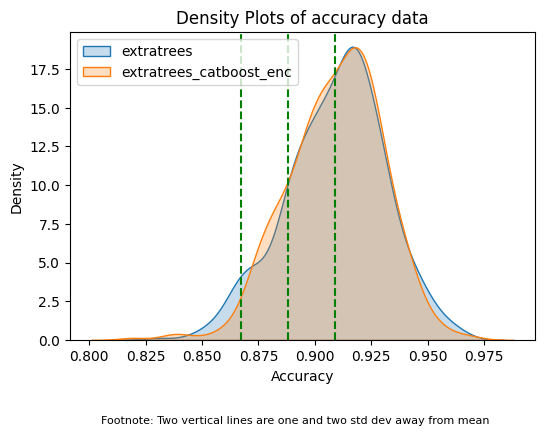

In [ ]:
# Choose the features you want to plot
features = ['extratrees', 'extratrees_catboost_enc']

_=plt.figure(figsize=(6,4))
for feature in features:
    _=sns.kdeplot(acc_array[feature], fill=True, label=feature)

_=plt.title('ExtraTrees vs ExtraTrees-catencoded--Density Plots of accuracy data',fontsize =10 )
_=plt.xlabel('Accuracy')
_=plt.ylabel('Density')
std = np.std(acc_array["extratrees_catboost_enc"])
mean = np.mean(acc_array["extratrees_catboost_enc"])
_=plt.axvline(x= mean - std * 1, color='g', linestyle='--')
_=plt.axvline(x= mean - std * 2, color='g', linestyle='--')
_=plt.axvline(x= mean , color='g', linestyle='--')
_=plt.figtext(0.5, -0.1, "Footnote: Two vertical lines are one and two std dev away from mean",
              ha="center",
              fontsize=8)

_=plt.legend()
_=plt.show()

## Voting classifier

In [ ]:
%%time

from sklearn.ensemble import  VotingClassifier



xgb_clf = XGBClassifier(booster = xgb_bst_param['booster'],
                        max_depth = xgb_bst_param['max_depth'],
                        n_estimators=200,
                        grow_policy = xgb_bst_param['grow_policy'],
                        colsample_bytree = xgb_bst_param['colsample_bytree'],
                        reg_lambda = xgb_bst_param['reg_lambda'],
                        reg_alpha = xgb_bst_param['reg_alpha'],
                        gamma =xgb_bst_param['gamma'],
                        learning_rate= xgb_bst_param['learning_rate'],
                        objective='binary:logistic',
                        #enable_categorical = True
                        )

extra_clf = ExtraTreesClassifier(n_estimators=550,
                           max_depth=None,
                           min_samples_split=2,
                           )

hist_classifier  = HistGradientBoostingClassifier(max_iter=400,
                                                 max_leaf_nodes=  hist_bst_param['max_leaf_nodes'],
                                                 l2_regularization = hist_bst_param['l2_regularization'],
                                                 categorical_features = cat_features,
                                                 learning_rate = hist_bst_param['learning_rate'],
                                                 max_features = hist_bst_param['max_features'],
                                                 #class_weight = 'balanced'
                                                 )

#rf_classifier = RandomForestClassifier(n_estimators=400)


eclf = VotingClassifier(estimators=[
                                    ('hist', hist_classifier),
                                    ('extra', extra_clf),
                                    #('rf', rf_classifier)
                                    ],
                         voting='soft')



total_acc_list = []
total_class0  = []
total_class1 = []
total_class2 = []
total_class3 = []
count = 1
for i in range(50):
  print("=========")
  print("ITERATION", i)
  print("=========")

  list_accu_stratified = []
  class0  = []    # [['precision', 'recall', 'f1-score', 'support'] ....]
  class1 = []
  class2 = []
  class3 = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      eclf.fit(X_train, y_train)
      print("Accuracy:", eclf.score(X_test, y_test))
      list_accu_stratified.append(eclf.score(X_test, y_test))
      sk = classification_report(y_test, eclf.predict(X_test), output_dict = True)
      class0.append(list(sk['0'].values()))  # [['precision', 'recall', 'f1-score', 'support']...]
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)



ITERATION 0
fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.89
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.875
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.9
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.914572864321608
fold: 5
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.9246231155778895
ITERATION 1
fold: 6
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.91
fold: 7
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.875
fold: 8
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.86
fold: 9
X_train shape: (799,

In [ ]:
print("========")
acc_array = np.array(total_acc_list)
acc_array.shape  # (50,5)
print("Overall Accuracy:", np.mean(acc_array))
print("Median Accuracy:", np.median(acc_array))
print("Std deviation of accuracy:", np.std(acc_array))
print("========")

(50, 5)

Overall Accuracy: 0.895751055276382
Median Accuracy: 0.895
Std deviation of accuracy: 0.023006834126292453


<Axes: xlabel='accuracy'>

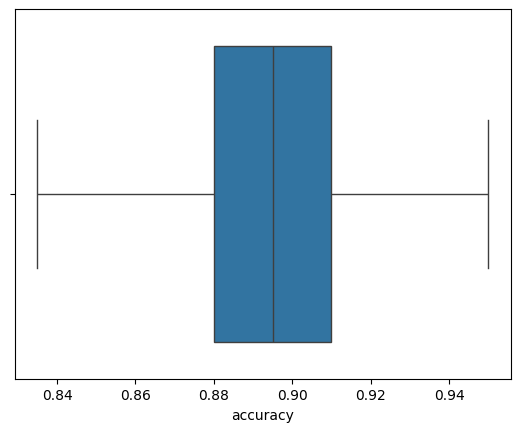

In [ ]:
acc = pd.DataFrame(acc_array.flatten(), columns = ["accuracy"])
sns.boxplot(data=acc, x="accuracy")


<Axes: xlabel='accuracy', ylabel='Density'>

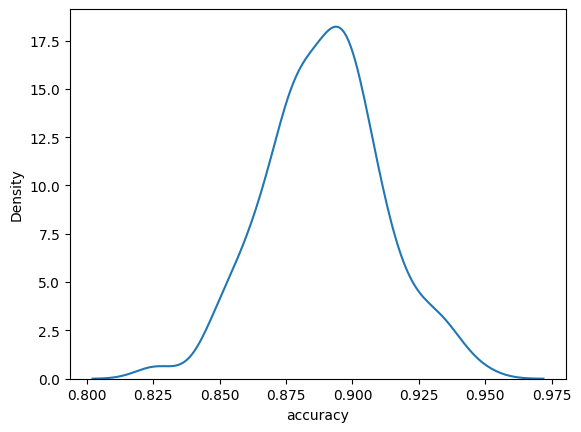

In [ ]:
sns.kdeplot(data=acc, x="accuracy")

## Stacking Classifier

In [ ]:
booster = 'dart',
colsample_bytree =  0.5,
gamma = np.float64(0.0034610752394487725),
grow_policy = 'depthwise',
learning_rate = 0.2,
max_depth = 8,
n_estimators = 200,
reg_alpha = np.float64(0.0003584127720728602),
reg_lambda = np.float64(0.002922484172354949)

# hist
l2_regularization= np.float64(0.0008536867093147364),
learning_rate=  0.1,
max_features = 0.9,
max_iter = 300,
max_leaf_nodes = 40,
min_samples_leaf = 20

In [ ]:
%%time


xgb_clf = XGBClassifier(booster = 'dart',
                        colsample_bytree =  0.5,
                        gamma = np.float64(0.0034610752394487725),
                        grow_policy = 'depthwise',
                        learning_rate = 0.2,
                        max_depth = 8,
                        n_estimators = 200,
                        reg_alpha = np.float64(0.0003584127720728602),
                        reg_lambda = np.float64(0.002922484172354949),
                        objective='binary:logistic',
                        )


extra_clf = ExtraTreesClassifier(criterion = 'entropy',n_estimators=150,
                           max_depth=None,
                           min_samples_split=2,
                           )


hist_classifier = HistGradientBoostingClassifier(l2_regularization= np.float64(0.0008536867093147364),
                                                  learning_rate=  0.1,
                                                  max_features = 0.9,
                                                  max_iter = 300,
                                                  max_leaf_nodes = 40,
                                                  min_samples_leaf = 20
                                                 )


extra_clf1 = ExtraTreesClassifier(n_estimators=350,
                                  max_depth=None,
                                  min_samples_split=2,
                                  )


sclf = StackingClassifier(estimators=[('xgb', xgb_clf),
                                      ('hist', hist_classifier),
                                       ('extra', extra_clf)],
                         final_estimator= extra_clf1,
                         n_jobs = -1,
                         passthrough = True,
                         cv = 5,
                         stack_method = 'predict_proba')

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
sclf.fit(X_train, y_train)

print(classification_report(y_test,
                      sclf.predict(X_test),
                      output_dict = True
                      ))

print("Accuracy:", sclf.score(X_test, y_test))


{'0': {'precision': 0.8780487804878049, 'recall': 0.935064935064935, 'f1-score': 0.9056603773584906, 'support': 77.0}, '1': {'precision': 0.8904109589041096, 'recall': 0.9285714285714286, 'f1-score': 0.9090909090909091, 'support': 140.0}, '2': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 24.0}, '3': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 9.0}, 'accuracy': 0.896, 'macro avg': {'precision': 0.9421149348479786, 'recall': 0.7992424242424242, 'f1-score': 0.8536878216123498, 'support': 250.0}, 'weighted avg': {'precision': 0.9010691613765452, 'recall': 0.896, 'f1-score': 0.8936343053173241, 'support': 250.0}}
Accuracy: 0.896
CPU times: user 2.18 s, sys: 287 ms, total: 2.47 s
Wall time: 34.3 s


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
neigh.score(X_test, y_test)

0.712

In [ ]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3,
                                                       weights = 'distance',
                                                       p=1
                                                       ),
                        n_estimators=100,max_features= 0.9,bootstrap_features=False
                        ).fit(X_train, y_train)


clf.score(X_test, y_test)

0.852

In [ ]:
%%time

from sklearn.ensemble import BaggingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)
clf = BaggingClassifier(estimator= GaussianProcessClassifier(kernel=kernel,n_jobs = -1),
                        n_estimators=10,n_jobs=-1
                        ).fit(X_train, y_train)


clf.score(X_test, y_test)

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(150, 150,150))


clf.fit(X_train, y_train)
clf.score(X_test, y_test)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(150, 150, 150), solver='lbfgs')

0.64

In [ ]:
xgb_clf = XGBClassifier(booster = 'dart',
                        colsample_bytree =  0.5,
                        gamma = np.float64(0.0034610752394487725),
                        grow_policy = 'depthwise',
                        learning_rate = 0.2,
                        max_depth = 8,
                        n_estimators = 200,
                        reg_alpha = np.float64(0.0003584127720728602),
                        reg_lambda = np.float64(0.002922484172354949),
                        objective='binary:logistic',
                        )


extra_clf = ExtraTreesClassifier(criterion = 'entropy',n_estimators=150,
                           max_depth=None,
                           min_samples_split=2,
                           )


hist_classifier = HistGradientBoostingClassifier(l2_regularization= np.float64(0.0008536867093147364),
                                                  learning_rate=  0.1,
                                                  max_features = 0.9,
                                                  max_iter = 300,
                                                  max_leaf_nodes = 40,
                                                  min_samples_leaf = 20
                                                 )


extra_clf1 = ExtraTreesClassifier(n_estimators=350,
                                  max_depth=None,
                                  min_samples_split=2,
                                  )

bag_clf = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3,
                                                       weights = 'distance',
                                                       p=1,
                                                       ),
                        n_estimators=10,
                        )


sclf = StackingClassifier(estimators=[('xgb', xgb_clf),
                                      ('hist', hist_classifier),
                                       ('extra', extra_clf),('bagging', bag_clf)
                                      ],
                         final_estimator= extra_clf1,
                         n_jobs = -1,
                         passthrough = True,
                         cv = 5,
                         stack_method = 'predict_proba')

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
sclf.fit(X_train, y_train)

print(classification_report(y_test,
                      sclf.predict(X_test),
                      output_dict = True
                      ))

print("Accuracy:", sclf.score(X_test, y_test))

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster='dart',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=np.float64(0.0034610752394487725),
                                              grow_policy='depthwise',
                                              importance_type=N...
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('extra',
                                ExtraTreesClassifier(criterion='entropy',
                                                     n_estimators=150)),
                               ('bagging',
                                BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3,
                                                                                 p=1,
                                                                                 weights='distance')))],
                   final_estimator=ExtraTreesClassifier(n_estimators=350),
                   n_jobs=-1, passthrough=True, stack_method='predict_proba')

{'0': {'precision': 0.8690476190476191, 'recall': 0.948051948051948, 'f1-score': 0.906832298136646, 'support': 77.0}, '1': {'precision': 0.9027777777777778, 'recall': 0.9285714285714286, 'f1-score': 0.9154929577464789, 'support': 140.0}, '2': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 24.0}, '3': {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 9.0}, 'accuracy': 0.9, 'macro avg': {'precision': 0.9429563492063492, 'recall': 0.8024891774891775, 'f1-score': 0.8555813139707813, 'support': 250.0}, 'weighted avg': {'precision': 0.9052222222222222, 'recall': 0.9, 'f1-score': 0.8975804041641152, 'support': 250.0}}
Accuracy: 0.9


In [ ]:
from sklearn.ensemble import  VotingClassifier



xgb_clf = XGBClassifier(booster = 'dart',
                        colsample_bytree =  0.5,
                        gamma = np.float64(0.0034610752394487725),
                        grow_policy = 'depthwise',
                        learning_rate = 0.2,
                        max_depth = 8,
                        n_estimators = 200,
                        reg_alpha = np.float64(0.0003584127720728602),
                        reg_lambda = np.float64(0.002922484172354949),
                        objective='binary:logistic',
                        )


extra_clf = ExtraTreesClassifier(criterion = 'entropy',n_estimators=150,
                           max_depth=None,
                           min_samples_split=2,
                           )


hist_classifier = HistGradientBoostingClassifier(l2_regularization= np.float64(0.0008536867093147364),
                                                  learning_rate=  0.1,
                                                  max_features = 0.9,
                                                  max_iter = 300,
                                                  max_leaf_nodes = 40,
                                                  min_samples_leaf = 20
                                                 )

#rf_classifier = RandomForestClassifier(n_estimators=400)


eclf = VotingClassifier(estimators=[
                                    ('hist', hist_classifier),
                                    ('extra', extra_clf),
                                    ('xgb', xgb_clf)
                                    ],
                         voting='soft')



total_acc_list = []
total_class0  = []
total_class1 = []
total_class2 = []
total_class3 = []
count = 1
for i in range(50):
  print("=========")
  print("ITERATION", i)
  print("=========")

  list_accu_stratified = []
  class0  = []    # [['precision', 'recall', 'f1-score', 'support'] ....]
  class1 = []
  class2 = []
  class3 = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      eclf.fit(X_train, y_train)
      print("Accuracy:", eclf.score(X_test, y_test))
      list_accu_stratified.append(eclf.score(X_test, y_test))
      sk = classification_report(y_test, eclf.predict(X_test), output_dict = True)
      class0.append(list(sk['0'].values()))  # [['precision', 'recall', 'f1-score', 'support']...]
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
xgb_clf = XGBClassifier(booster = 'dart',
                        colsample_bytree =  0.5,
                        gamma = np.float64(0.0034610752394487725),
                        grow_policy = 'depthwise',
                        learning_rate = 0.2,
                        max_depth = 8,
                        n_estimators = 200,
                        reg_alpha = np.float64(0.0003584127720728602),
                        reg_lambda = np.float64(0.002922484172354949),
                        objective='binary:logistic',
                        )


extra_clf = ExtraTreesClassifier(criterion = 'entropy',
                                 n_estimators=350,
                                 max_depth=None,
                                 min_samples_split=2,
                                 )


hist_classifier = HistGradientBoostingClassifier(l2_regularization= np.float64(0.0008536867093147364),
                                                  learning_rate=  0.1,
                                                  max_features = 0.9,
                                                  max_iter = 300,
                                                  max_leaf_nodes = 40,
                                                  min_samples_leaf = 20
                                                 )



eclf = VotingClassifier(estimators=[
                                    ('hist', hist_classifier),
                                    ('extra', extra_clf),
                                    ('xgb', xgb_clf)
                                    ],
                         voting='soft')

# Define the parameter grid for weights
params = {'weights': [[0.5,1,0.5],
                      [0.7,1,0.7],
                       [0.9,1,0.9]]}

# Use GridSearchCV to find the best weights
grid = GridSearchCV(estimator=eclf,
                          param_grid=params,
                          cv=5, n_jobs = -1)
# Fit the grid search to your data (X, y)
grid.fit(X_train, y_train)
# Print the best weights and score
print("Best weights:", grid.best_params_)
print("Best score:", grid.best_score_)



Best weights: {'weights': [0.5, 1, 0.5]}
Best score: 0.925829145728643
CPU times: user 10min 24s, sys: 4.41 s, total: 10min 28s
Wall time: 7min 36s


In [ ]:
%%time
import statistics
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
xgb_clf = XGBClassifier(booster = 'dart',
                        colsample_bytree =  0.5,
                        gamma = np.float64(0.0034610752394487725),
                        grow_policy = 'depthwise',
                        learning_rate = 0.2,
                        max_depth = 8,
                        n_estimators = 200,
                        reg_alpha = np.float64(0.0003584127720728602),
                        reg_lambda = np.float64(0.002922484172354949),
                        objective='binary:logistic',
                        )


extra_clf = ExtraTreesClassifier(criterion = 'entropy',
                                 n_estimators=350,
                                 max_depth=None,
                                 min_samples_split=2,
                                 )


hist_classifier = HistGradientBoostingClassifier(l2_regularization= np.float64(0.0008536867093147364),
                                                  learning_rate=  0.1,
                                                  max_features = 0.9,
                                                  max_iter = 300,
                                                  max_leaf_nodes = 40,
                                                  min_samples_leaf = 20
                                                 )



bag_clf = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3,
                                                       weights = 'distance',
                                                       p=1,
                                                       ),
                        n_estimators=10,
                        )



eclf = VotingClassifier(estimators=[
                                    ('extra', extra_clf),
                                    ('bag', bag_clf)
                                    ],weights = [1,0.5],
                                    voting='soft')

total_acc_list = []
total_class0  = []
total_class1 = []
total_class2 = []
total_class3 = []
count = 1
sum_acc = []
for i in range(50):
  print("=========")
  print("ITERATION", i)
  print("=========")

  list_accu_stratified = []
  class0  = []    # [['precision', 'recall', 'f1-score', 'support'] ....]
  class1 = []
  class2 = []
  class3 = []
  skf = StratifiedKFold(n_splits=5,
                        shuffle=True)

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]
      print("=======")
      print("fold:", count ) ; count = count +1
      print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
      print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
      # Now you can use X_train, X_test, y_train, y_test for training and evaluating your model in each fold
      eclf.fit(X_train, y_train)
      acc = eclf.score(X_test, y_test)
      print("Accuracy:", acc)
      sum_acc.append(acc)
      cum_mean_acc = (sum(sum_acc))/(count-1)
      print("Cumulative mean accuracy:", cum_mean_acc)
      if count > 3:
        print("std deviation of avg mean:", statistics.stdev(sum_acc))
      list_accu_stratified.append(eclf.score(X_test, y_test))
      sk = classification_report(y_test, eclf.predict(X_test), output_dict = True)
      class0.append(list(sk['0'].values()))  # [['precision', 'recall', 'f1-score', 'support']...]
      class1.append(list(sk['1'].values()))
      class2.append(list(sk['2'].values()))
      class3.append(list(sk['3'].values()))

  total_acc_list.append(list_accu_stratified)
  total_class0.append(class0)
  total_class1.append(class1)
  total_class2.append(class2)
  total_class3.append(class3)



ITERATION 0
fold: 1
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.88
Cumulative mean accuracy: 0.88
fold: 2
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.925
Cumulative mean accuracy: 0.9025000000000001
fold: 3
X_train shape: (798, 12) y_train shape: (798,)
X_test shape: (200, 12) y_test shape: (200,)
Accuracy: 0.9
Cumulative mean accuracy: 0.9016666666666667
std deviation of avg mean: 0.022546248764114492
fold: 4
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.8743718592964824
Cumulative mean accuracy: 0.8948429648241206
std deviation of avg mean: 0.022915944585217424
fold: 5
X_train shape: (799, 12) y_train shape: (799,)
X_test shape: (199, 12) y_test shape: (199,)
Accuracy: 0.9195979899497487
Cumulative mean accuracy: 0.8997939698492463
std deviation of avg mean: 0.02272482433306499
ITERATION 1
fold: 6
X_train sha

## Feature engineering (experimental)
(Experimental)

In [ ]:
dfx = df.copy()
y = dfx.pop('cormack lehane')
X = dfx
encoder = ce.CatBoostEncoder(cols=["sex", "edentulous", "mouth opening", "head and neck movement"])
encoder.fit(X, y)
X_catEncoded = encoder.transform(X)

NameError: name 'X' is not defined

In [ ]:
X_catEncoded.head()

In [ ]:
df['bmi'].min()
df['bmi'].max()
(df['bmi'].max() - df['bmi'].min())/4


In [ ]:
df['height'].min()
df['height'].max()
(df['height'].max() - df['height'].min())/4


In [ ]:
bmi_cat = pd.cut(df["bmi"],
       bins=[13, 19, 25, 31, 38],
       labels=["0", "1", "2", "3"])

In [ ]:
height_cat = pd.cut(df["height"],
       bins=[130, 146, 162, 178, 195],
       labels=["0", "1", "2", "3"])

In [ ]:
bmi_cat = pd.DataFrame(bmi_cat)
bmi_cat.head()

In [ ]:
height_cat = pd.DataFrame(height_cat)
height_cat.head()

In [ ]:
bmi_cat.rename(columns = {'bmi':'bmi_cat'}, inplace = True)
bmi_cat.head()

In [ ]:
height_cat.rename(columns = {'height':'height_cat'}, inplace = True)
height_cat.head()

In [ ]:
df['bmi_cat'] = bmi_cat

In [ ]:
df['height_cat'] = height_cat

In [ ]:
df.head()

In [ ]:
dfc = df.copy()
y = dfc.pop('cormack lahane')
X = dfc




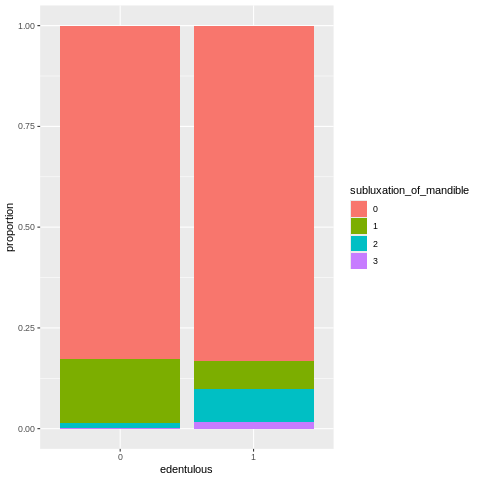

In [ ]:
%%R

temp <- df_r %>%
 group_by(edentulous, subluxation_of_mandible) %>%
  dplyr::count() %>%
  group_by(edentulous) %>%
  mutate(proportion = n/sum(n))

ggplot(temp, aes(x=edentulous,
                 y=proportion,
                 fill= subluxation_of_mandible)) +
        geom_bar(stat='identity')

